In [3]:
# --- PyTorch Core Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# --- Torchvision Imports for Image Handling ---
import torchvision
from torchvision import datasets, models, transforms

# --- Data Science and Plotting Imports ---
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [ ]:
# --- Main Settings ---
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 25

# --- Data Paths (IMPORTANT: Use your absolute path) ---
# Example: 'C:/Users/YourUser/Desktop/chest_xray_data/chest_xray'
data_directory = 'C:/Users/abdul/Desktop/XRay-CNN-Project/chest_xray/chest_xray'

train_data_path = os.path.join(data_directory, 'train')
validation_data_path = os.path.join(data_directory, 'val')

# --- Set the device for training ---
# This will be 'cuda' if you have a working GPU setup, otherwise 'cpu'
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available for training.")
else:
    device = torch.device("cpu")
    print("GPU not available, training on CPU.")

GPU is available for training.


In [12]:
# Define transformations for the training data (with data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for the validation data (only resizing and normalization)
validation_transforms = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Load the datasets from folders ---
train_dataset = datasets.ImageFolder(
    root=train_data_path,
    transform=train_transforms
)

validation_dataset = datasets.ImageFolder(
    root=validation_data_path,
    transform=validation_transforms
)

# --- Create data loaders with parallel workers ---
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,  # Use 4 parallel processes to load data
    pin_memory=True # Helps speed up CPU to GPU data transfer
)

validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Print class names
print(f"Classes found: {train_dataset.classes}")

Classes found: ['NORMAL', 'PNEUMONIA']


In [13]:
# --- Load the pre-trained VGG16 model ---
model = models.vgg16(weights='IMAGENET1K_V1')

# --- Freeze all the layers in the model ---
# We do this so we don't change the pre-trained features
for parameter in model.parameters():
    parameter.requires_grad = False

# --- Replace the last layer (the classifier) ---
# Get the number of input features for the last layer
num_input_features = model.classifier[6].in_features

# Create our new custom classifier
custom_classifier = nn.Sequential(
    nn.Linear(in_features=num_input_features, out_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=512, out_features=2) # 2 classes: NORMAL, PNEUMONIA
)

# Replace the old classifier with our new one
model.classifier[6] = custom_classifier

# --- Move the model to the GPU (if available) ---
model = model.to(device)

# --- Define the Loss Function and Optimizer ---
# CrossEntropyLoss is good for classification problems
loss_function = nn.CrossEntropyLoss()

# We only want to train the parameters of our new classifier
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

# Print the model structure
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# --- Model Training Loop ---

# Store history for plotting later
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train() # Set the model to training mode
    
    train_loss_total = 0.0
    train_correct_predictions = 0
    
    # Loop over the training data batches
    for inputs, labels in train_loader:
        # Move data to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 1. Forward pass: Make predictions
        predictions = model(inputs)
        
        # 2. Calculate the loss
        loss = loss_function(predictions, labels)
        
        # 3. Backward pass: Calculate gradients
        optimizer.zero_grad() # Reset gradients
        loss.backward()
        
        # 4. Update the weights
        optimizer.step()
        
        # Track total loss and correct predictions
        train_loss_total += loss.item()
        _, predicted_labels = torch.max(predictions, 1)
        train_correct_predictions += (predicted_labels == labels).sum().item()

    # --- Validation Phase ---
    model.eval() # Set the model to evaluation mode
    
    val_loss_total = 0.0
    val_correct_predictions = 0
    
    with torch.no_grad(): # We don't need to calculate gradients for validation
        # Loop over the validation data batches
        for inputs, labels in validation_loader:
            # Move data to the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Make predictions
            predictions = model(inputs)
            
            # Calculate the loss
            loss = loss_function(predictions, labels)
            
            # Track total loss and correct predictions
            val_loss_total += loss.item()
            _, predicted_labels = torch.max(predictions, 1)
            val_correct_predictions += (predicted_labels == labels).sum().item()
            
    # --- Calculate average loss and accuracy for the epoch ---
    avg_train_loss = train_loss_total / len(train_loader)
    train_accuracy = train_correct_predictions / len(train_dataset)
    
    avg_val_loss = val_loss_total / len(validation_loader)
    val_accuracy = val_correct_predictions / len(validation_dataset)
    
    # Save history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)
    
    # Print results for the epoch
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

print("Training finished.")

Epoch 1/25 | Train Loss: 0.2445 | Train Acc: 0.8967 | Val Loss: 0.3505 | Val Acc: 0.8125
Epoch 2/25 | Train Loss: 0.2131 | Train Acc: 0.9147 | Val Loss: 0.2384 | Val Acc: 0.9375
Epoch 3/25 | Train Loss: 0.2043 | Train Acc: 0.9201 | Val Loss: 0.2618 | Val Acc: 0.9375
Epoch 4/25 | Train Loss: 0.1835 | Train Acc: 0.9248 | Val Loss: 0.2267 | Val Acc: 0.9375
Epoch 5/25 | Train Loss: 0.1870 | Train Acc: 0.9264 | Val Loss: 0.1850 | Val Acc: 0.9375
Epoch 6/25 | Train Loss: 0.1790 | Train Acc: 0.9279 | Val Loss: 0.2095 | Val Acc: 0.9375
Epoch 7/25 | Train Loss: 0.1830 | Train Acc: 0.9252 | Val Loss: 0.2012 | Val Acc: 0.9375
Epoch 8/25 | Train Loss: 0.1833 | Train Acc: 0.9262 | Val Loss: 0.1956 | Val Acc: 1.0000
Epoch 9/25 | Train Loss: 0.1695 | Train Acc: 0.9291 | Val Loss: 0.1641 | Val Acc: 0.9375
Epoch 10/25 | Train Loss: 0.1779 | Train Acc: 0.9239 | Val Loss: 0.2336 | Val Acc: 0.9375
Epoch 11/25 | Train Loss: 0.1846 | Train Acc: 0.9270 | Val Loss: 0.1642 | Val Acc: 0.9375
Epoch 12/25 | Train

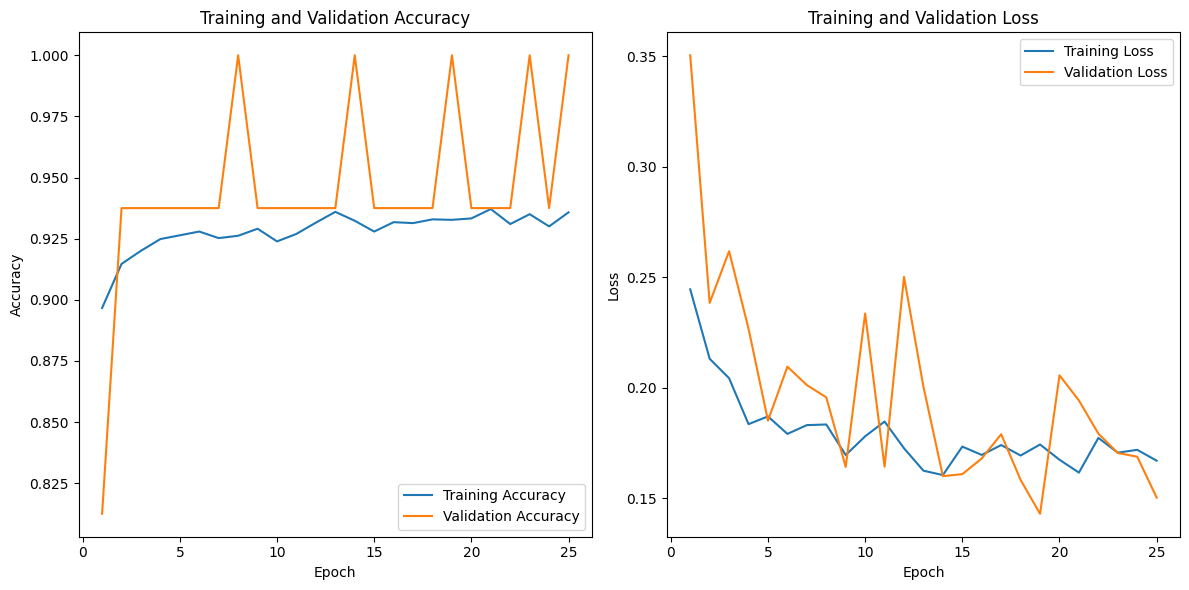

In [16]:
# --- Plot Training History ---

# Get accuracy and loss from history
train_accuracy_history = history['train_acc']
validation_accuracy_history = history['val_acc']
train_loss_history = history['train_loss']
validation_loss_history = history['val_loss']

# Create a list of epoch numbers
epochs_range = range(1, EPOCHS + 1)

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy_history, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, validation_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [18]:
# --- Define the path to the test data ---
TEST_DIR = os.path.join(data_directory, 'test')

# --- Use the same transformations as the validation set ---
test_transforms = validation_transforms # Re-using the validation transforms

# --- Create the test dataset and dataloader ---
test_dataset = datasets.ImageFolder(
    root=TEST_DIR,
    transform=test_transforms
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle for evaluation
    num_workers=4,
    pin_memory=True
)

print(f"Test dataset contains {len(test_dataset)} images.")

Test dataset contains 624 images.


In [23]:
# Re-define the class_names variable from the training dataset
class_names = train_dataset.classes

# Print to confirm
print(f"Class names successfully defined: {class_names}")

Class names successfully defined: ['NORMAL', 'PNEUMONIA']


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.66      0.77       234
   PNEUMONIA       0.83      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.86      0.85      0.85       624



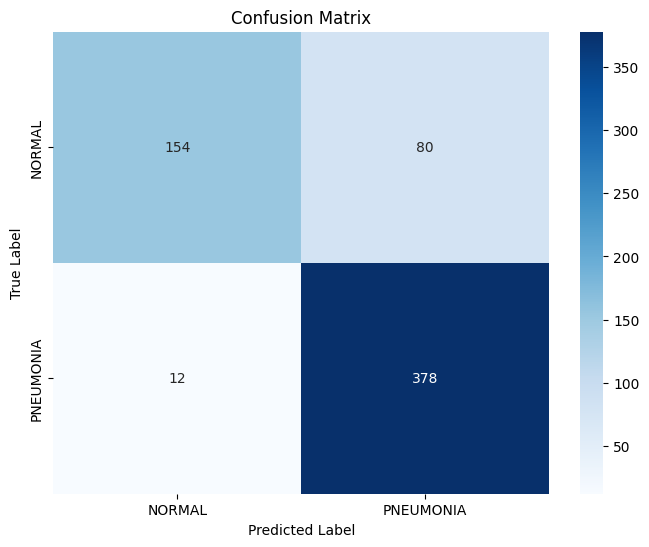

In [24]:
# Import scikit-learn for detailed metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- Set model to evaluation mode ---
model.eval()

# --- Store all predictions and true labels ---
all_preds = []
all_labels = []

with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Print the Classification Report ---
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# --- Generate and Plot the Confusion Matrix ---
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

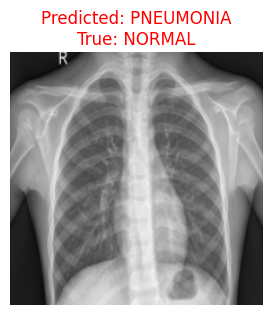

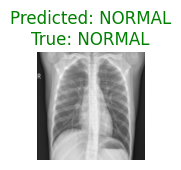

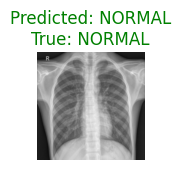

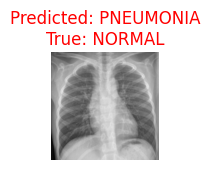

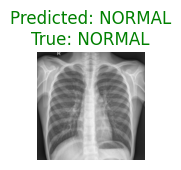

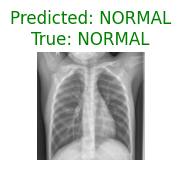

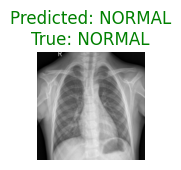

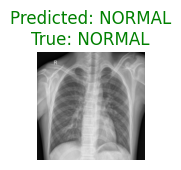

In [25]:
# --- Function to un-normalize and show an image ---
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# --- Get a batch of test data ---
inputs, classes = next(iter(test_loader))

# --- Move data to the device and make predictions ---
inputs = inputs.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# --- Plot the images with their predicted labels ---
plt.figure(figsize=(15, 10))
for i in range(8): # Display the first 8 images in the batch
    ax = plt.subplot(2, 4, i + 1)
    ax.axis('off')
    
    # --- Create the title with prediction and true label ---
    predicted_class = class_names[preds[i]]
    true_class = class_names[classes[i]]
    
    # Set title color to green for correct, red for incorrect
    title_color = 'green' if predicted_class == true_class else 'red'
    ax.set_title(f'Predicted: {predicted_class}\nTrue: {true_class}', color=title_color)

    # --- Display the image ---
    imshow(inputs.cpu().data[i])

plt.show()